In [1]:
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [29]:
countries = ['DE', 'ES', 'FR', 'GB', 'IT']
naive_df = pd.read_csv('results/naive/metrics_persistence_countries_minmax.csv', header=[0, 1], index_col=[0, 1]).loc[:, ('Persistence', ['RMSE', 'MAE'])]
arima_df = pd.read_csv('results/arima/metrics_arima_countries_minmax.csv', header=[0, 1], index_col=[0, 1]).loc[:, ('(S)ARIMA', ['RMSE', 'MAE'])]
informer_df = pd.read_csv('results/informer/informer.csv', header=[0, 1], index_col=[0, 1]).loc[:, ('Informer', ['RMSE', 'MAE'])]
patchtst_df = pd.read_csv('results/patchtst/patchtst_128.csv', header=[0, 1], index_col=[0, 1]).loc[:, ('PatchTST/42', ['RMSE', 'MAE'])]

all_df = pd.concat([naive_df, arima_df, informer_df, patchtst_df], axis=1).round(3)
all_df


Model            Persistence        (S)ARIMA        Informer         \
Metrics                 RMSE    MAE     RMSE    MAE     RMSE    MAE   
Country Pred_len                                                      
DE      24             0.196  0.139    0.077  0.065    0.162  0.104   
        96             0.261  0.197    0.213  0.171    0.207  0.143   
        168            0.234  0.170    0.183  0.142    0.231  0.159   
ES      24             0.141  0.094    0.097  0.083    0.152  0.092   
        96             0.197  0.139    0.202  0.150    0.229  0.143   
        168            0.177  0.124    0.224  0.165    0.228  0.147   
FR      24             0.122  0.080    0.058  0.048    0.112  0.064   
        96             0.178  0.125    0.181  0.141    0.150  0.090   
        168            0.163  0.108    0.233  0.187    0.156  0.097   
GB      24             0.199  0.144    0.152  0.132    0.180  0.120   
        96             0.255  0.194    0.265  0.228    0.225  0.158   
        168            0.247  0.186    0.211  0.173    0.245  0.170   
IT      24             0.144  0.097    0.119  0.095    0.112  0.066   
        96             0.197  0.141    0.169  0.121    0.144  0.089   
        168            0.157  0.109    0.180  0.130    0.149  0.097   

Model            PatchTST/42         
Metrics                 RMSE    MAE  
Country Pred_len                     
DE      24             0.145  0.088  
        96             0.193  0.128  
        168            0.200  0.135  
ES      24             0.099  0.060  
        96             0.137  0.088  
        168            0.145  0.094  
FR      24             0.101  0.055  
        96             0.138  0.081  
        168            0.144  0.087  
GB      24             0.160  0.101  
        96             0.209  0.142  
        168            0.215  0.149  
IT      24             0.101  0.057  
        96             0.136  0.081  
        168            0.144  0.087

In [31]:
patchtst_64_df = pd.read_csv('results/patchtst/patchtst_bs128_pl512.csv', header=[0, 1], index_col=[0, 1]).loc[:, ('PatchTST/64', ['RMSE', 'MAE'])]
self_supervised = pd.read_csv('results/patchtst/finetune_results.csv', header=[0, 1], index_col=[0, 1]).loc[:, ('Self-supervised', ['RMSE', 'MAE'])]
self_supervised

Model            Self-supervised          
Metrics                     RMSE       MAE
Country Pred_len                          
DE      24              0.146501  0.089918
        96              0.188671  0.125538
        168             0.194498  0.131626
GB      24              0.157274  0.099986
        96              0.203277  0.139292
        168             0.208057  0.144780
ES      24              0.097570  0.058944
        96              0.136096  0.086611
        168             0.146636  0.094115
FR      24              0.100289  0.054945
        96              0.143982  0.082077
        168             0.147566  0.086637
IT      24              0.101562  0.058244
        96              0.137453  0.082549
        168             0.143234  0.087093

In [127]:
# Load results from all models

# Persistence
#naive_cols_df = pd.read_csv('results/naive/metrics_persistence_columns.csv', header=[0], index_col=[0, 1, 2])
naive_countries_df = pd.read_csv('results/naive/metrics_persistence_countries.csv', header=[0, 1], index_col=[0, 1])

# (S)ARIMA
arima_cols_df = pd.read_csv('results/arima/metrics_arima_columns.csv', header=[0], index_col=[0, 1, 2])
arima_countries_df = pd.read_csv('results/arima/metrics_arima_countries.csv', header=[0, 1], index_col=[0, 1])

# Informer
#informer_cols_df = pd.read_csv('results/informer/metrics_informer_columns.csv', header=[0], index_col=[0, 1, 2])
informer_countries_df = pd.read_csv('dataset_results/informer_loss_functions_results_scaled_minmax_0_5_relu.csv', header=[0], index_col=[0, 1])

# PatchTST
patchtst_countries_df = pd.read_csv('dataset_results/patchtst_loss_functions_results_scaled_minmax_0_5_relu.csv', header=[0], index_col=[0, 1])

In [128]:
# Groupby iterations
informer_countries_df = informer_countries_df.groupby(['Pred_len', 'Loss_function']).mean()[['MSE', 'MAE', 'RMSE']]
patchtst_countries_df = patchtst_countries_df.groupby(['Pred_len', 'Loss_function']).mean()[['MSE', 'MAE', 'RMSE']]

informer_countries_df.columns = pd.MultiIndex.from_product([['Informer'], ['MSE', 'MAE', 'RMSE']], names=['Model', 'Metrics'])
patchtst_countries_df.columns = pd.MultiIndex.from_product([['PatchTST'], ['MSE', 'MAE', 'RMSE']], names=['Model', 'Metrics'])

In [129]:
# Temporary results
naive = naive_countries_df[naive_countries_df.index.get_level_values('Country') == 'DE'].droplevel('Country')
arima = arima_countries_df[arima_countries_df.index.get_level_values('Country') == 'DE'].droplevel('Country')
informer_countries_df = informer_countries_df[informer_countries_df.index.get_level_values('Loss_function') == 'MAE'].droplevel('Loss_function')
patchtst_countries_df = patchtst_countries_df[patchtst_countries_df.index.get_level_values('Loss_function') == 'MAE'].droplevel('Loss_function')

# MSE

In [118]:
all_df = pd.concat([naive, arima, informer_countries_df, patchtst_countries_df], axis=1)
all_df

Model    Persistence                    (S)ARIMA                      \
Metrics          MSE      MAE     RMSE       MSE       MAE      RMSE   
Pred_len                                                               
24           0.69368  1.16806  0.98076  0.318047  0.177510  0.371851   
96           0.98462  1.95272  1.30688  0.770241  0.993926  0.932496   
168          0.85048  1.72070  1.16962  0.754590  0.974105  0.952523   

Model     Informer                      PatchTST                      
Metrics        MSE       MAE      RMSE       MSE       MAE      RMSE  
Pred_len                                                              
24        0.573227  0.507549  0.757037  0.534640  0.471388  0.731190  
96        1.000880  0.711158  1.000347  0.899636  0.659464  0.948480  
168       1.033869  0.724725  1.016766  0.952140  0.684722  0.975757

# MAE

In [130]:
all_df = pd.concat([naive, arima, informer_countries_df, patchtst_countries_df], axis=1)
all_df

Model    Persistence                    (S)ARIMA                      \
Metrics          MSE      MAE     RMSE       MSE       MAE      RMSE   
Pred_len                                                               
24           0.69368  1.16806  0.98076  0.318047  0.177510  0.371851   
96           0.98462  1.95272  1.30688  0.770241  0.993926  0.932496   
168          0.85048  1.72070  1.16962  0.754590  0.974105  0.952523   

Model     Informer                      PatchTST                      
Metrics        MSE       MAE      RMSE       MSE       MAE      RMSE  
Pred_len                                                              
24        0.597535  0.492688  0.772978  0.540867  0.449922  0.735436  
96        1.018232  0.696228  1.008985  0.909122  0.632491  0.953435  
168       1.057604  0.715416  1.028395  0.980713  0.669754  0.990265

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results_comparison(data, eval_metric='RMSE'):
    """
    Plots the results comparison between all models with the specific evaluation 
    metric. This function can automatically subset the data with a specific evaluation 
    metric.

    Args:
        data (pandas.DataFrame): The dataframe to plot. 
        eval_metric (str): The evaluation metric to plot (default: 'RMSE').
    Returns:
        None
    """
    # Define markers and colors for each model
    models = ['Persistence', '(S)ARIMA', 'Informer', 'PatchTST']
    markers = ['o', 's', '*', '^'] # , 'X'
    colors = ['blue', 'green', 'orange', 'red'] # 'purple'

    # Create the plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot each model with its line and marker
    for idx, model in enumerate(models):
        subset = data.loc[:, (model, eval_metric)]
        ax.plot(subset.index, subset.values, marker=markers[idx], color=colors[idx], label=model, linestyle='-')

    # Create a custom legend outside the loop
    legend_elements = [plt.Line2D([0], [0], marker=markers[i], color='w', markerfacecolor=colors[i], markersize=12, label=models[i])
                   for i in range(len(models))]

    # Add the legend to the plot
    ax.legend(handles=legend_elements, title="Models", loc="best")

    # Add axis labels
    ax.set_xlabel('Prediction Length (Pred_len)', fontsize=11)
    ax.set_ylabel('Value', fontsize=12)
    ax.set_xticks([24, 96, 168])

    # Show the plot
    plt.suptitle('Comparison of Models with {}'.format(eval_metric), fontsize=12)
    plt.tight_layout()
    plt.show()


# Loss function MAE

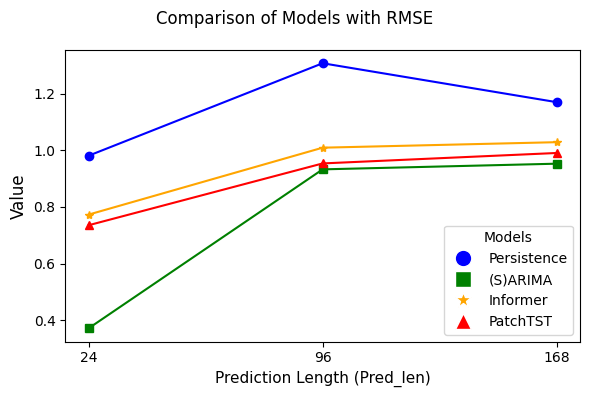

In [112]:
plot_results_comparison(all_df, eval_metric='RMSE')

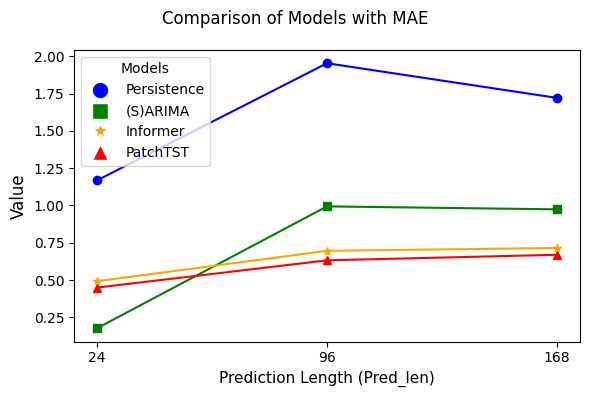

In [113]:
plot_results_comparison(all_df, eval_metric='MAE')

# Loss function MSE

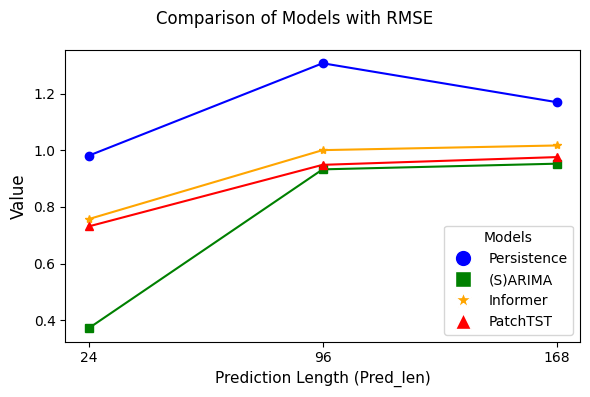

In [119]:
plot_results_comparison(all_df, eval_metric='RMSE')

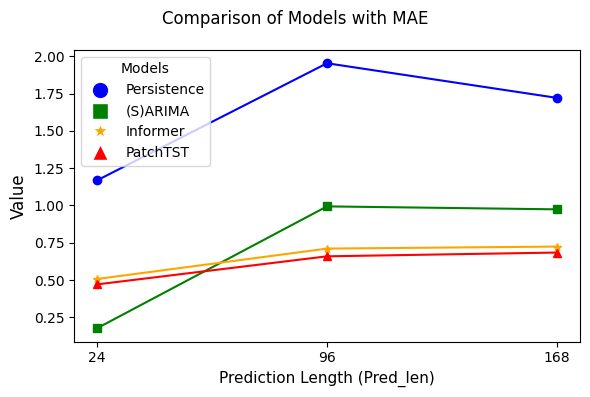

In [120]:
plot_results_comparison(all_df, eval_metric='MAE')

Averaged metrics per country.

In [167]:
# Loop over multiindex dataframe to get the columns that start with country index
# and also loop over the metrics to average

top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
metrics = ['MAE', 'MSE', 'RMSE']

mse_values = {}
mae_values = {}
rmse_values = {}

for country in top_5_countries:
    for metric in metrics:
        columns = [(col, metric) for col in metrics_df.columns.levels[0] if col.startswith(country)]
        for col, _ in columns:
            values = metrics_df[col, metric].dropna().tolist()
            
            if country not in mse_values:
                mse_values[country] = []
            if country not in mae_values:
                mae_values[country] = []
            if country not in rmse_values:
                rmse_values[country] = []

            if values:
                if metric == 'MAE':
                    mae_values[country].extend(values)
                elif metric == 'MSE':
                    mse_values[country].extend(values)
                elif metric == 'RMSE':
                    rmse_values[country].extend(values)

# Calculate average values for each metric
average_mse_arima = {country: sum(values) / len(values) for country, values in mse_values.items()}
average_mae_arima = {country: sum(values) / len(values) for country, values in mae_values.items()}
average_rmse_arima = {country: sum(values) / len(values) for country, values in rmse_values.items()}

# Create DataFrames for ARIMA model
arima_countries_df = pd.DataFrame({'MSE': average_mse_arima, 'MAE': average_mae_arima})

# Add MultiIndex columns 
arima_countries_df.columns = pd.MultiIndex.from_product([['ARIMA'], arima_countries_df.columns])


# Informer results

Average results countries.

In [170]:
import re

# Change to your path
file_path = "/Users/valentyna/Documents/Master_thesis_new/results/Informer/result_long_term_forecast.txt"

# Read the file and split lines
with open(file_path, "r") as file:
    data = file.readlines()

# Create dictionaries to store MSE and MAE values for each country
mse_values = {}
mae_values = {}

# Iterate through lines in groups of three
for i in range(0, len(data), 3):
    # Extract country code from the line using regular expression
    match = re.search(r'long_term_forecast__24_([A-Z]{2})_Informer', data[i])
    if match:
        country = match.group(1)
        # Initialize lists for MSE and MAE values if not already present
        if country not in mse_values:
            mse_values[country] = []
        if country not in mae_values:
            mae_values[country] = []
        # Extract MSE value from the MSE line
        mse_value = re.search(r'mse:(.*?),', data[i+1])
        if mse_value:
            mse = float(mse_value.group(1).strip())
            mse_values[country].append(mse)
        # Extract MAE value from the MAE line
        mae_value = re.search(r'mae:(.*?)\n', data[i+1])
        if mae_value:
            mae = float(mae_value.group(1).strip())
            mae_values[country].append(mae)

# Calculate average MSE and MAE for each country
average_mse_informer = {country: sum(values) / len(values) for country, values in mse_values.items()}
average_mae_informer = {country: sum(values) / len(values) for country, values in mae_values.items()}

# Create DataFrames for Informer
informer_countries_df = pd.DataFrame({'MSE': average_mse_informer, 'MAE': average_mae_informer})

# Add MultiIndex columns for both models
informer_countries_df.columns = pd.MultiIndex.from_product([['Informer'], informer_countries_df.columns])

Average results per column. It is a bit harder than for countries, therefore I placed it in other order, than for models above.

In [157]:
top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']

# Dictionaries to store MSE and MAE values for each column
mse_values_dict = {}
mae_values_dict = {}

for country in top_5_countries:
    columns = [col for col in metrics_df.columns.levels[0] if col.startswith(country)]
    
    for i, col in enumerate(columns):

        # Initialize lists to store MSE and MAE values for the current column
        mse_values = []
        mae_values = []
        
        # Iterate over experiment numbers
        for j in range(2):
            path = "/Users/valentyna/Documents/Master_thesis_new/results/Informer/long_term_forecast__24_"
            path_2 = "_Informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl5_df2048_fc5_ebtimeF_dtTrue_Exp_"
            
            exp_number = j
            path_full = path + country + path_2 + str(exp_number)

            pred = np.load(path_full + "/pred.npy")[:, :, i]
            true = np.load(path_full + "/true.npy")[:, :, i]

            #mse = mean_squared_error(true, pred)
            #mae = mean_absolute_error(true, pred)
            mse = mean_squared_error(pred, true)
            mae = mean_absolute_error(pred, true)

            # Append MSE and MAE values to the lists
            mse_values.append(mse)
            mae_values.append(mae)
        
        # Store MSE and MAE values for the current column
        mse_values_dict[col] = mse_values
        mae_values_dict[col] = mae_values


In [158]:
# Dictionary to store average MSE and MAE values for each column
average_values_dict = {}

# Calculate average MSE and MAE for each column
for column in mse_values_dict.keys():
    mse_values = mse_values_dict[column]
    mae_values = mae_values_dict[column]
    
    # Calculate average MSE and MAE
    average_mse = np.mean(mse_values)
    average_mae = np.mean(mae_values)
    
    # Store the average values in the dictionary
    average_values_dict[column] = {'MSE': average_mse, 'MAE': average_mae}

In [171]:
# Create a DataFrame with MultiIndex
informer_cols_df = pd.DataFrame.from_dict(average_values_dict, orient='index')

# Add a MultiIndex for columns
informer_cols_df.columns = pd.MultiIndex.from_product([['Informer'], ['MSE', 'MAE']], names=['Model', 'Metrics'])

# Results of all models

In [175]:
# Concatenate the DataFrames for Columns dataframes
df_cols = pd.concat([naive_cols_df.iloc[:, :2], arima_cols_df.iloc[:, :2], informer_cols_df], axis=1)

df_cols

Model                                      Naive               ARIMA  \
Metrics                                      MSE       MAE       MSE   
DE_load_actual_entsoe_transparency      0.406823  0.383997  0.471867   
DE_solar_generation_actual              0.175201  0.144906  0.188723   
DE_wind_generation_actual               0.809237  1.146706  0.651457   
DE_wind_offshore_generation_actual      1.241636  2.582417  0.893363   
DE_wind_onshore_generation_actual       0.764757  1.072277  0.647845   
ES_load_actual_entsoe_transparency      0.356224  0.305231  0.331985   
ES_solar_generation_actual              0.244915  0.210993  0.187641   
ES_wind_onshore_generation_actual       0.744900  0.912025  0.455867   
FR_load_actual_entsoe_transparency      0.238754  0.140010  0.190246   
FR_solar_generation_actual              0.178166  0.138144  0.192786   
FR_wind_onshore_generation_actual       0.980366  1.796839  0.945161   
GB_UKM_load_actual_entsoe_transparency  0.275282  0.161476  0.255775   
GB_UKM_solar_generation_actual          0.222510  0.220427  0.237781   
GB_UKM_wind_generation_actual           0.958276  1.559749  0.759619   
GB_UKM_wind_offshore_generation_actual  1.290048  2.835774  1.177409   
GB_UKM_wind_onshore_generation_actual   0.825123  1.162277  0.548707   
IT_load_actual_entsoe_transparency      0.379766  0.367459  0.364290   
IT_solar_generation_actual              0.129736  0.077675  0.117752   
IT_wind_onshore_generation_actual       0.808517  1.119023  0.512943   

Model                                             Informer            
Metrics                                      MAE       MSE       MAE  
DE_load_actual_entsoe_transparency      0.361086  0.120858  0.249314  
DE_solar_generation_actual              0.112712  0.151555  0.226218  
DE_wind_generation_actual               0.836964  0.644801  0.582968  
DE_wind_offshore_generation_actual      1.620248  1.185348  0.849587  
DE_wind_onshore_generation_actual       0.795603  0.625351  0.565995  
ES_load_actual_entsoe_transparency      0.220536  0.110779  0.234938  
ES_solar_generation_actual              0.126489  0.603296  0.454738  
ES_wind_onshore_generation_actual       0.420360  0.544108  0.544694  
FR_load_actual_entsoe_transparency      0.072617  0.071693  0.187501  
FR_solar_generation_actual              0.112883  0.126935  0.213305  
FR_wind_onshore_generation_actual       1.348464  0.994235  0.680911  
GB_UKM_load_actual_entsoe_transparency  0.118962  0.144596  0.282156  
GB_UKM_solar_generation_actual          0.138101  0.210975  0.270608  
GB_UKM_wind_generation_actual           0.928757  0.860881  0.708348  
GB_UKM_wind_offshore_generation_actual  2.064870  1.587935  0.993076  
GB_UKM_wind_onshore_generation_actual   0.538438  0.645331  0.611427  
IT_load_actual_entsoe_transparency      0.260970  0.071046  0.178702  
IT_solar_generation_actual              0.049520  0.066081  0.144016  
IT_wind_onshore_generation_actual       0.675289  0.529392  0.530946

In [176]:
# Concatenate the DataFrames for Countries dataframes
df_countries = pd.concat([naive_countries_df.iloc[:, :2], arima_countries_df.iloc[:, :2], informer_countries_df], axis=1)

df_countries

Naive               ARIMA            Informer          
         MSE       MAE       MSE       MAE       MSE       MAE
DE  0.679531  1.066061  0.745322  0.570651  0.545583  0.494817
GB  0.714248  1.187940  0.757825  0.595858  0.689944  0.573123
ES  0.448680  0.476083  0.255795  0.325165  0.419394  0.411457
FR  0.465762  0.691664  0.511321  0.442731  0.397621  0.360572
IT  0.439340  0.521386  0.328593  0.331661  0.222173  0.284555

In [ ]:
# Loop over multiindex dataframe to get the columns that start with country index
# and also loop over the metrics to average

top_5_countries = ['DE', 'GB', 'ES', 'FR', 'IT']
metrics = ['MAE', 'MSE', 'RMSE']

for country in top_5_countries:
    print(f"Country: {country}")
    country_columns = [(col, metric) for col, metric in metrics_df.columns if col.startswith(country)]
    for metric in metrics:
        metric_columns = [(col, metric) for col, m in country_columns if m == metric]
        if metric_columns:
            values_to_average = metrics_df[metric_columns].values.flatten()
            mean_value = values_to_average.mean()
            print(f"Mean {metric}: {mean_value}")
        else:
            print(f"No data for metric {metric} in country {country}")
    print()